# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.









## Настройка окружения.

In [ ]:
# !pip install pandas
# !pip install sklearn
# !pip install catboost
!pip install pandas_profiling
!pip install category_encoders
# !pip install lightgbm
!pip install pgeocode
!pip install optuna
# !pip install seaborn
# !pip install matplotlib
# !pip install warnings

     |████████████████████████████████| 324 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 344 kB 22.4 MB/s eta 0:00:01
     |████████████████████████████████| 679 kB 70.6 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 96.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 94.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 83.1 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 94.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 63.9 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=77e74c67eeb1c75cd9663bc3c5b5566f063a4c4391092e5bbdeda222460c9bb2
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin
     |████████████████████████████████| 81 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 365 kB 1.3 MB/s eta 0:00:01


In [ ]:
# загружаем библиотеки нужные
import pandas as pd
import warnings # supress warnings
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from collections import Counter
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
from pandas_profiling import ProfileReport
from lightgbm import LGBMRegressor
import re
import numpy as np
import pgeocode
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders
from sklearn.preprocessing import OneHotEncoder


/tmp/ipykernel_490/1743017770.py:11: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [ ]:
# игнорируем будущие ошибки
warnings.filterwarnings('ignore')

## Подготовка данных


In [ ]:
# загружаем и читаем данные
df = pd.read_csv(r'/datasets/autos.csv')



In [ ]:
# смотрим 2 строчки таблицы
df.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


In [ ]:
# функция для подсчетов типов
def counter_of_type(data):
    return Counter(data.dtypes)


In [ ]:
# Функция для ознакомления с данными
def preview(data,n_row=4,
             head=True,
             info=True,
             columns=True,
             shape=True,
             isna=True,
             duplicated=True,
             dtypes_=True,
            describe_=True,
           clear_duples=True,
           lower_and_sep_col=True):
    global dct_nan
    global df_nan_columns
    dct_nan = {}
    if head:
        print(f'First {n_row} row(s) in the head of data')
        display(data.head(n_row))
        print('-'*30)
    if info:
        print('Data Information:')
        display(data.info())
        print('-'*30)
    if columns:
        print('Data columns:')
        display(data.columns)
        if lower_and_sep_col:
            COLUMN_REG = "(\w)([A-Z])"
            repl = r"\1_\2"
            data.columns = list(map(lambda x: re.sub(COLUMN_REG,repl,x).lower(),data.columns))
            print('Lowered and sepperated by words columns:')
            print(data.columns)
            print('-'*30)
    if shape:
        print('Data shape:')
        display(data.shape)
        print('-'*30)
    if isna:
        print('Data isna by row mean:')
        display(data.isna().mean())
        print()
        tmp = data.isna().mean()
        for i in range(len(tmp)):

            if tmp[i] > 0:
                dct_nan[tmp.index[i]] = tmp[i]
        if tmp.sum() > 0:
            df_nan_columns = pd.DataFrame.from_dict(dct_nan.items())
            df_nan_columns.columns = ['column','rate_of_nan']
            display(df_nan_columns)
        print('-'*30)
    if duplicated:
        print('Data clear duplicates sum:')
        duplets = data.duplicated().sum()
        display(duplets)
        if duplets >1 and clear_duples:
            data.drop_duplicates(inplace=True)
            print('Successful delete of {0} duplicates'.format(duplets))
        elif duplets == 1 and clear_duples:
            data.drop_duplicates(inplace=True)
            print('Successful delete of {0} duplicate'.format(duplets))
        print('-'*30)
    if dtypes_:
        print('Data dtypes:')
        display(data.dtypes)
        print('Number of each type:')
        print(counter_of_type(data))
        print('-'*30)
    if describe_:
        print('Major statistics for data:')
        display(data.describe())


In [ ]:
# используем функцию
preview(df)

NameError: name 'df' is not defined

**Вывод:**



Были найдены 4 явных дубликата, которые после запуска функции preview были удалены из настоящей таблицы. Стоит проверить наличие неявных дубликатов, поскольку есть столбцы с максимальным кол-вом уникальных значений, которые будут мешать выявлению дубликатов.




In [ ]:
# корреляция столбцов
df.select_dtypes(include='number').corr()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
price,1.000000,0.026916,0.158872,-0.333207,0.110580,NaN,0.076058
registration_year,0.026916,1.000000,-0.000828,-0.053448,-0.011619,NaN,-0.003459
power,0.158872,-0.000828,1.000000,0.024006,0.043379,NaN,0.021662
kilometer,-0.333207,-0.053448,0.024006,1.000000,0.009575,NaN,-0.007685
registration_month,0.110580,-0.011619,0.043379,0.009575,1.000000,NaN,0.013996
number_of_pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,0.076058,-0.003459,0.021662,-0.007685,0.013996,NaN,1.000000


In [ ]:
# отобразим численные столбцы
df.select_dtypes(include='number')

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
0,480,1993,0,150000,0,0,70435
1,18300,2011,190,125000,5,0,66954
2,9800,2004,163,125000,8,0,90480
3,1500,2001,75,150000,6,0,91074
4,3600,2008,69,90000,7,0,60437
...,...,...,...,...,...,...,...
354364,0,2005,0,150000,7,0,2694
354365,2200,2005,0,20000,1,0,39576
354366,1199,2000,101,125000,3,0,26135
354367,9200,1996,102,150000,3,0,87439


In [ ]:
# копирую таблицы
df_for_model = df.copy()

In [ ]:
# имена столбцов
df_for_model.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [ ]:
# удаляем ненужный столбец
df_for_model.drop(columns='date_crawled',axis=1,inplace=True)

In [ ]:
# 5 строк проказываю
df_for_model.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
# список индексов
crawled_del_duplets = df_for_model[df_for_model.duplicated() ==True].index

In [ ]:
# посмотрим на возможные ошибки в объявлении от одного пользователя
df_for_model[(df_for_model['postal_code'] == 46562) & (df_for_model['kilometer'] == 90000)]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
6689,15700,suv,2011,manual,190,other,90000,6,petrol,mini,no,2016-03-16 00:00:00,0,46562,2016-03-27 16:47:23
49694,15700,suv,2011,manual,189,other,90000,6,petrol,mini,no,2016-03-16 00:00:00,0,46562,2016-03-27 14:16:03
77480,15700,suv,2011,manual,189,other,90000,6,petrol,mini,no,2016-03-16 00:00:00,0,46562,2016-03-27 14:16:03
165821,3990,small,2007,manual,60,panda,90000,11,petrol,fiat,no,2016-03-30 00:00:00,0,46562,2016-04-05 23:17:40
245099,3750,small,2009,manual,65,other,90000,5,petrol,fiat,no,2016-03-19 00:00:00,0,46562,2016-03-28 19:48:17
269728,2350,small,2004,manual,75,clio,90000,1,petrol,renault,no,2016-03-24 00:00:00,0,46562,2016-04-06 23:45:12
276987,3750,small,2009,manual,65,other,90000,5,petrol,fiat,no,2016-03-19 00:00:00,0,46562,2016-03-28 20:18:51
286190,15700,suv,2011,manual,190,cooper,90000,6,petrol,mini,no,2016-03-16 00:00:00,0,46562,2016-04-06 00:45:57
289334,3750,small,2009,manual,64,punto,90000,5,petrol,fiat,no,2016-03-13 00:00:00,0,46562,2016-03-29 03:16:29
334938,2600,small,2004,manual,75,clio,90000,4,petrol,renault,no,2016-03-23 00:00:00,0,46562,2016-04-05 13:46:36


In [ ]:
# смотрим на уникальные значения и количестве оных
df_for_model['power'].value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: power, Length: 712, dtype: int64

In [ ]:
# сколько дубликатов если выбрать столбцы
# 'price','vehicle_type','registration_year','gearbox','power',
# 'kilometer','registration_month','fuel_type','brand','repaired'
df_for_model.loc[(df_for_model['power'] >= 189) & (df_for_model['power'] <= 190)]
df_for_model.loc[:,['price','vehicle_type','registration_year','gearbox','power','kilometer','registration_month','fuel_type','brand','repaired']].duplicated().sum()

29876

In [ ]:
# таблица со столбцами
# 'price','vehicle_type','registration_year','gearbox','kilometer','registration_month'
df_for_model.loc[:,['price','vehicle_type','registration_year','gearbox','kilometer','registration_month']]

,price,vehicle_type,registration_year,gearbox,kilometer,registration_month
0,480,NaN,1993,manual,150000,0
1,18300,coupe,2011,manual,125000,5
2,9800,suv,2004,auto,125000,8
3,1500,small,2001,manual,150000,6
4,3600,small,2008,manual,90000,7
...,...,...,...,...,...,...
354364,0,NaN,2005,manual,150000,7
354365,2200,NaN,2005,NaN,20000,1
354366,1199,convertible,2000,auto,125000,3
354367,9200,bus,1996,manual,150000,3


In [ ]:
# сумма дубликатов в таблице со столбцами
# 'price','vehicle_type','registration_year','gearbox','kilometer','registration_month'
df_for_model.loc[:,['price','vehicle_type','registration_year','gearbox','kilometer','registration_month']].duplicated().sum()

117483

In [ ]:
# смотрим на строки с индексами 77480,77479
df_for_model.query('index in [77480,77479]')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
77479,850,bus,1995,auto,170,voyager,150000,1,NaN,chrysler,no,2016-03-21 00:00:00,0,31249,2016-04-05 22:45:39
77480,15700,suv,2011,manual,189,other,90000,6,petrol,mini,no,2016-03-16 00:00:00,0,46562,2016-03-27 14:16:03


In [ ]:
# строки с дубликатами
df_for_model.query('index in @ crawled_del_duplets')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
77480,15700,suv,2011,manual,189,other,90000,6,petrol,mini,no,2016-03-16 00:00:00,0,46562,2016-03-27 14:16:03
84075,999,small,2002,manual,50,lupo,150000,6,petrol,volkswagen,no,2016-03-15 00:00:00,0,48499,2016-03-21 03:16:25
84868,6990,small,2008,manual,75,500,80000,1,gasoline,fiat,no,2016-04-03 00:00:00,0,65428,2016-04-07 13:16:12
87362,13990,wagon,2009,manual,190,a6,150000,7,gasoline,audi,no,2016-03-17 00:00:00,0,61350,2016-04-06 23:45:28
90786,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,2016-04-01 00:00:00,0,99974,2016-04-07 06:15:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333106,5500,wagon,2007,auto,163,3er,150000,7,gasoline,bmw,no,2016-03-24 00:00:00,0,12623,2016-04-06 21:46:54
345034,15000,convertible,1975,NaN,0,spider,50000,1,NaN,alfa_romeo,no,2016-04-03 00:00:00,0,51061,2016-04-05 18:17:30
349989,17999,wagon,2011,auto,143,a4,90000,8,gasoline,audi,no,2016-03-26 00:00:00,0,55130,2016-04-07 00:17:35
354151,8450,wagon,2007,auto,140,passat,150000,1,gasoline,volkswagen,no,2016-03-28 00:00:00,0,18233,2016-04-01 04:46:10


In [ ]:
# таблица с объектами
df.select_dtypes(exclude='number')

,date_crawled,vehicle_type,gearbox,model,fuel_type,brand,repaired,date_created,last_seen
0,2016-03-24 11:52:17,NaN,manual,golf,petrol,volkswagen,NaN,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,coupe,manual,NaN,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,suv,auto,grand,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,small,manual,golf,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,small,manual,fabia,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,NaN,manual,colt,petrol,mitsubishi,yes,2016-03-21 00:00:00,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,NaN,NaN,NaN,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,convertible,auto,fortwo,petrol,smart,no,2016-03-05 00:00:00,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,bus,manual,transporter,gasoline,volkswagen,no,2016-03-19 00:00:00,2016-04-07 07:15:26


In [ ]:
# уникальные значения в столбце number_of_pictures
df['number_of_pictures'].value_counts()

0    354365
Name: number_of_pictures, dtype: int64

In [ ]:
# таблица с пропущенными значениями
df_nan_columns

,column,rate_of_nan
0,vehicle_type,0.105794
1,gearbox,0.055967
2,model,0.055606
3,fuel_type,0.092827
4,repaired,0.200791


In [ ]:
# находим столбцы с категориальным значением other
fill_other_lst = []
def check_other_cat(data,rows):

    for row in rows:
        if 'other' in map(lambda x: str(x).strip().lower(),data[row].unique()):
            fill_other_lst.append(row)

In [ ]:
# применяем функцию вышеописанную
check_other_cat(df_for_model,df_nan_columns['column'])

In [ ]:
# список столбцов, в которых есть other
fill_other_lst

['vehicle_type', 'model', 'fuel_type']

**Вывод:**

Подметим, что в столбце количества фотографий везде стоит 0.

С точки зренья примитивной логики кол-во фотографий никак не дорлжно влиять на цену, а при том факте, что везде стоит "0", мы можем убрать весь столбец без каких-либо потерь

Также, даты скачивания, создания анкеты, последняя активность владельца и почтовый индекс владельца объявления никак не влияет на стоимость автомобиля.

Пропущенные значения в колонках `vehicle_type`, `model` и `fuel_type` стоит заменить на `other`. Остальные **NaN** удалю для чистоты данных.


In [ ]:
# заполняем пропуски other
for i in fill_other_lst:
    df_for_model[i].fillna(value='other',inplace=True)

In [ ]:
# смотрим на столбец
df_for_model['number_of_pictures']

0         0
1         0
2         0
3         0
4         0
         ..
354364    0
354365    0
354366    0
354367    0
354368    0
Name: number_of_pictures, Length: 354365, dtype: int64

In [ ]:
# удаляем ненужный признак
df_for_model.drop('number_of_pictures',axis=1,inplace=True)

In [ ]:
# смотрим корреляцию
# df_for_model.select_dtypes(include='number').corr()

In [ ]:
# смотрим корреляцию
df_for_model.select_dtypes(include='number').corr(method='spearman')


,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.550986,0.512607,-0.314414,0.155245,0.078935
registration_year,0.550986,1.000000,0.160186,-0.294574,0.052692,0.034937
power,0.512607,0.160186,1.000000,0.084522,0.128823,0.081059
kilometer,-0.314414,-0.294574,0.084522,1.000000,-0.011115,-0.017076
registration_month,0.155245,0.052692,0.128823,-0.011115,1.000000,0.014936
postal_code,0.078935,0.034937,0.081059,-0.017076,0.014936,1.000000


In [ ]:
#  смотрим пропущенные по всей таблицы
df_for_model.isna().sum()

price                     0
vehicle_type              0
registration_year         0
gearbox               19833
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
repaired              71154
date_created              0
postal_code               0
last_seen                 0
dtype: int64

In [ ]:
# отсекаем выбросы и аномальные значения
df_for_model = df_for_model[df_for_model['power'].between(1,1000)]

In [ ]:
#  смотрим среднее значение power по gearbox
df_for_model.groupby('gearbox')['power'].mean()

gearbox
auto      167.051917
manual    109.115171
Name: power, dtype: float64

In [ ]:
# собираем таблицы по gearbox
gearbox_auto_mean = df_for_model.groupby('gearbox')['power'].mean()[0]
gearbox_manual_mean = df_for_model.groupby('gearbox')['power'].mean()[1]

In [ ]:
# смотрим на столбец power с gearbox==manual и repaired значения пропущенные
manual_rep_nan = df_for_model[((df_for_model['gearbox']=='manual') & (df_for_model['repaired'].isna()))]['power']

In [ ]:
# максимальное значения power
manual_rep_nan.max()

1000

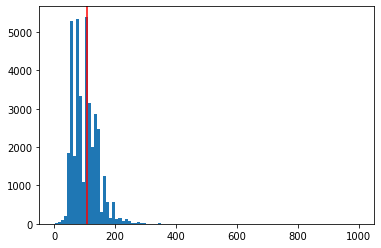

109.11517078983435

In [ ]:
# смотрим на гистограмму power в таблицы gearbox==manual и repaired значения
plt.hist(manual_rep_nan,bins=100,range=[manual_rep_nan.min(),manual_rep_nan.max()])
plt.axvline(gearbox_manual_mean,color='r')
plt.show()
gearbox_manual_mean

In [ ]:
# аналогично
auto_rep_nan  = df_for_model[((df_for_model['gearbox']=='auto') & (df_for_model['repaired'].isna()))]['power']

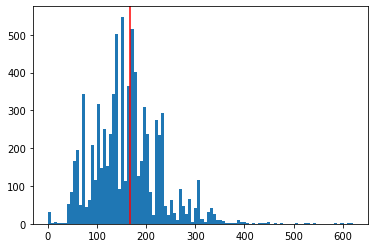

167.0519171928911

In [ ]:
# смотрим на гистограмму power в таблицы gearbox==auto и repaired значения

plt.hist(auto_rep_nan,bins=100,range=[auto_rep_nan.min(),auto_rep_nan.max()])
plt.axvline(gearbox_auto_mean,color='r')
plt.show()
gearbox_auto_mean

In [ ]:
# заполняем пропуски так, что меньше 110 это manual
df_for_model.loc[((df_for_model['gearbox'].isna() == True) & (df_for_model['power']<=109)),'gearbox'] = 'manual'

In [ ]:
# заполняем пропуски так, что больше 167 это auto

df_for_model.loc[((df_for_model['gearbox'].isna() == True) & (df_for_model['power']>=167)),'gearbox'] = 'auto'

In [ ]:
# считаем пропуски в gearbox
gearbox_nan = df_for_model['gearbox'].isna().sum()

In [ ]:
# заполняем случайно
df_for_model['gearbox'].fillna(value='auto',limit=gearbox_nan//2,inplace=True)

In [ ]:
# заполняем случайно

df_for_model['gearbox'].fillna(value='manual',limit=gearbox_nan//2,inplace=True)

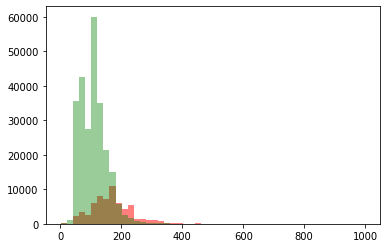

In [ ]:
# посмотрим на разборс power относительно gearbox
plt.hist(df_for_model[df_for_model['gearbox']=='auto']['power'],alpha=0.5,bins=50,color='red')
plt.hist(df_for_model[df_for_model['gearbox']=='manual']['power'],alpha=0.4,bins=50,color='g')
plt.show()

In [ ]:
# пропуски в столбце repaired
df_for_model['repaired'].isna().sum()

49633

In [ ]:
# функция для категоризации
# цены
def price_interval(row):
    if row <= 5000:
        return '0-5000'
    if 5000 < row <= 10000:
        return '5000-1000'
    if 10000< row <= 15_000:
        return '10000-15000'
    if 15_000<row<=20000:
        return '15000-20000'



In [ ]:
# применяем функцию по категоризации
df_for_model['price_interval'] = df_for_model['price'].apply(price_interval)

In [ ]:
# группировка по price_interval, repaired считаем сколько строк price
tmp_1= df_for_model.groupby(['price_interval','repaired'])['price'].agg(['count'])

In [ ]:
tmp_1

count
price_interval repaired        
0-5000         no        139700
               yes        28049
10000-15000    no         24889
               yes          600
15000-20000    no         13394
               yes          208
5000-1000      no         54988
               yes         2377

In [ ]:
# аналогия и делаем считаем снизу процент пропусков
tmp_2 = df_for_model.groupby(['price_interval'])['repaired'].agg(['size','count'])

In [ ]:
tmp_2['diff'] = tmp_2['size'] - tmp_2['count']

In [ ]:
tmp_2['percent'] =  tmp_2['diff']/tmp_2['size']

In [ ]:
tmp_2

,size,count,diff,percent
price_interval,,,,
0-5000,208343,167749,40594,0.194842
10000-15000,27423,25489,1934,0.070525
15000-20000,14442,13602,840,0.058164
5000-1000,63630,57365,6265,0.098460


In [ ]:
df_for_model.groupby(['repaired'])['price'].agg(['mean'])

,mean
repaired,
no,5429.309648
yes,2038.247038


In [ ]:
#  средняя цена у машин, которые прошли ремонт
df_for_model[((df_for_model['repaired']=='no')& (df_for_model['price']))]['price'].mean()

5205.8498263438905

In [ ]:
#  средняя цена у машин, которые не прошли ремонт


df_for_model[((df_for_model['repaired']=='yes')& (df_for_model['price']))]['price'].mean()

2205.9805879090404

<AxesSubplot:>

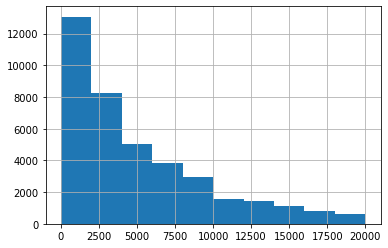

In [ ]:
# гистограмма вышего
df_for_model[((df_for_model['repaired']=='no')& (df_for_model['price']))]['price'].hist()

<AxesSubplot:>

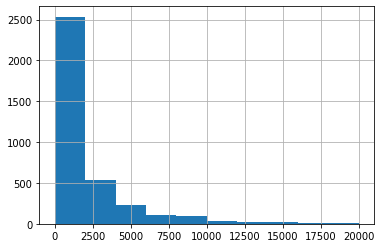

In [ ]:
# гистограмма вышего
df_for_model[((df_for_model['repaired']=='yes')& (df_for_model['price']))]['price'].hist()

In [ ]:
# заполняем относительно средней цены
df_for_model.loc[((df_for_model['price']<=2205) &(df_for_model['repaired'].isna()==True)),'repaired']='yes'

In [ ]:
# заполняем относительно средней цены

df_for_model.loc[((df_for_model['price']>2205) &(df_for_model['repaired'].isna()==True)),'repaired']='no'

In [ ]:
# корелляция
df_for_model.corr(method='spearman')

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.593699,0.504080,-0.357265,0.103779,0.069718
registration_year,0.593699,1.000000,0.165097,-0.342641,0.035753,0.032281
power,0.504080,0.165097,1.000000,0.118378,0.048358,0.064349
kilometer,-0.357265,-0.342641,0.118378,1.000000,-0.023433,-0.018275
registration_month,0.103779,0.035753,0.048358,-0.023433,1.000000,0.006171
postal_code,0.069718,0.032281,0.064349,-0.018275,0.006171,1.000000


In [ ]:
# заполняем пропуски и одновременно переводим в bool
df_for_model['repaired'] = np.where(df_for_model['repaired']=='yes',1,0)

In [ ]:
# проверка
df_for_model['repaired'].isna().sum()

0

In [ ]:
# корреляция
df_for_model.corr(method='spearman')['price']

price                 1.000000
registration_year     0.593699
power                 0.504080
kilometer            -0.357265
registration_month    0.103779
repaired             -0.459297
postal_code           0.069718
Name: price, dtype: float64

In [ ]:
# ProfileReport(df)

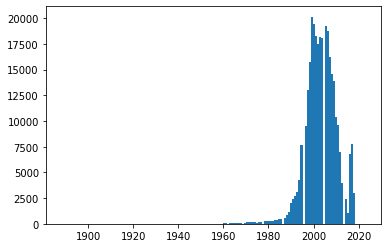

In [ ]:
# обрезаем год от первого автомобиля до сегодня
plt.hist(df_for_model['registration_year'],bins=150,range=(1888,2023))
plt.show()


In [ ]:
# применяем отрез
df_for_model = df_for_model[df_for_model['registration_year'].between(1888,2023)]

In [ ]:
# проверка
df_for_model.registration_year.min()

1910

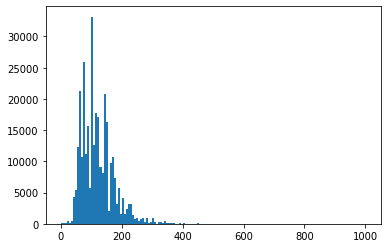

In [ ]:
# проверка
plt.hist(df_for_model['power'],bins=150,range=(0,1000))
plt.show()

In [ ]:
# имена стобцов
df_for_model.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'postal_code', 'last_seen',
       'price_interval'],
      dtype='object')

In [ ]:
# удаляем столбцы 'last_seen','postal_code','date_created'
df_for_model.drop(columns=['last_seen','postal_code','date_created'],axis=1,inplace=True)

In [ ]:
# смотрим голову таблицы
df_for_model.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,price_interval
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,1,15000-20000
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0,5000-1000
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0,0-5000
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,0-5000
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,1,0-5000


In [ ]:
# сумма дубликатов
df_for_model.duplicated().sum()

26723

In [ ]:
df_for_model.shape

(313801, 12)

In [ ]:
# убираем дубликаты
df_for_model.drop_duplicates(inplace=True)

In [ ]:
# обновляем индексы
df_for_model = df_for_model.reset_index(drop=True)

In [ ]:
df_for_model

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,price_interval
0,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,1,15000-20000
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0,5000-1000
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0,0-5000
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,0-5000
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,1,0-5000
...,...,...,...,...,...,...,...,...,...,...,...,...
287073,5250,other,2016,auto,150,159,150000,12,other,alfa_romeo,0,5000-1000
287074,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,1,0-5000
287075,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,0,0-5000
287076,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,0,5000-1000


In [ ]:
df_for_model

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,price_interval
0,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,1,15000-20000
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0,5000-1000
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0,0-5000
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,0-5000
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,1,0-5000
...,...,...,...,...,...,...,...,...,...,...,...,...
287073,5250,other,2016,auto,150,159,150000,12,other,alfa_romeo,0,5000-1000
287074,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,1,0-5000
287075,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,0,0-5000
287076,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,0,5000-1000


In [ ]:
# таблица с будущими категориальными значениями
df_for_model_cat = df_for_model.copy()

In [ ]:
df_for_model_cat.select_dtypes(exclude='number')

,vehicle_type,gearbox,model,fuel_type,brand,price_interval
0,coupe,manual,other,gasoline,audi,15000-20000
1,suv,auto,grand,gasoline,jeep,5000-1000
2,small,manual,golf,petrol,volkswagen,0-5000
3,small,manual,fabia,gasoline,skoda,0-5000
4,sedan,manual,3er,petrol,bmw,0-5000
...,...,...,...,...,...,...
287073,other,auto,159,other,alfa_romeo,5000-1000
287074,sedan,manual,leon,petrol,seat,0-5000
287075,convertible,auto,fortwo,petrol,smart,0-5000
287076,bus,manual,transporter,gasoline,volkswagen,5000-1000


In [ ]:
# обрезаем и уменьшаем регистры строк
def strip_lower_str(row):
    return row.strip().lower()

In [ ]:
# имена категоиральных столбцов
obj_columns = df_for_model_cat.select_dtypes(exclude='number').columns

In [ ]:
# применяем ко всем столбцам функция
for i in obj_columns:
    df_for_model_cat[i] = df_for_model_cat[i].apply(strip_lower_str)

In [ ]:
# поиск двоичных категоричных столбцов
two_cat_lst_col = []
for i in obj_columns:
    print('Number of unique values in ', i)
    n_unique = df_for_model_cat[i].nunique()
    print(n_unique)
    if n_unique <=2:
        two_cat_lst_col.append(i)
    print()
    print('Unique values: ')
    print(df_for_model_cat[i].value_counts())
    print('-'*30)

Number of unique values in  vehicle_type
8

Unique values: 
sedan          76933
small          65080
wagon          54847
bus            24442
other          24281
convertible    17462
coupe          13972
suv            10061
Name: vehicle_type, dtype: int64
------------------------------
Number of unique values in  gearbox
2

Unique values: 
manual    229749
auto       57329
Name: gearbox, dtype: int64
------------------------------
Number of unique values in  model
249

Unique values: 
other                 32797
golf                  24023
3er                   16463
polo                  10340
corsa                  9622
                      ...  
samara                    5
kalina                    4
serie_3                   3
rangerover                3
range_rover_evoque        1
Name: model, Length: 249, dtype: int64
------------------------------
Number of unique values in  fuel_type
7

Unique values: 
petrol      179397
gasoline     81826
other        20604
lpg          

In [ ]:

two_cat_lst_col

['gearbox']

**ВЫВОД:**

* Были очищены данные от выбросов
* Пропущенные значения были заменены относительно средних значений в столбце `power` и `price` соответственно


## Анализ моделей


In [ ]:
df_for_model_cat.drop(columns='price_interval',inplace=True)

In [ ]:
df_for_model_cat.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

In [ ]:
# таблица для catboost and lightgbm
catlightgbm_df = df_for_model_cat.copy()


In [ ]:
# обозначаем признаки и таргет для случайного леса
features = df_for_model_cat.drop('price',axis=1)
target = df_for_model_cat.price

In [ ]:
rs=7


In [ ]:
# делим на тренировочные и тестовые
features_train,features_tv,target_train,target_tv=train_test_split(features,target,test_size=0.4,random_state=rs)


In [ ]:
features_valid,features_test,target_valid,target_test=train_test_split(features_tv,target_tv,test_size=0.4,random_state=rs)


In [ ]:
# иницилизация кодировщика
OHE =  OneHotEncoder()

In [ ]:
# столбец для OHE
gearbox_train =  features_train['gearbox']

In [ ]:
gearbox_train.values

array(['manual', 'manual', 'manual', ..., 'manual', 'manual', 'manual'],
      dtype=object)

In [ ]:
gearbox_train.value_counts()

manual    137819
auto       34427
Name: gearbox, dtype: int64

In [ ]:
gearbox_test = features_test['gearbox']

In [ ]:
gearbox_test.value_counts()

manual    36907
auto       9026
Name: gearbox, dtype: int64

In [ ]:
gearbox_valid = features_valid['gearbox']
gearbox_valid.value_counts()

manual    55023
auto      13876
Name: gearbox, dtype: int64

In [ ]:
tmp_0 = OHE.fit_transform(gearbox_train.values.reshape(-1, 1))
tmp_1 = OHE.fit_transform(gearbox_test.values.reshape(-1, 1))
tmp_2 = OHE.fit_transform(gearbox_valid.values.reshape(-1, 1))

In [ ]:
gerbox_dt_ohe_0 = pd.DataFrame(tmp_0.toarray(),columns=OHE.categories_)
gerbox_dt_ohe_1 = pd.DataFrame(tmp_1.toarray(),columns=OHE.categories_)
gerbox_dt_ohe_2 = pd.DataFrame(tmp_2.toarray(),columns=OHE.categories_)

In [ ]:
gerbox_dt_ohe_0.head(1)

,auto,manual
0,0.0,1.0


In [ ]:
gerbox_dt_ohe_1.head(1)

,auto,manual
0,0.0,1.0


In [ ]:
features_train.head(1)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
148720,small,2006,manual,94,justy,30000,4,petrol,subaru,0


In [ ]:
# обнуляем индексы и обновляем
features_train = features_train.reset_index(drop=True)

In [ ]:
# обнуляем индексы и обновляем

features_test = features_test.reset_index(drop=True)

In [ ]:
# обнуляем индексы и обновляем
features_valid = features_valid.reset_index(drop=True)

In [ ]:
# присоединяем кодированные данные

features_train = pd.concat([features_train,gerbox_dt_ohe_0],axis=1)

In [ ]:
# присоединяем кодированные данные
features_test= pd.concat([features_test,gerbox_dt_ohe_1],axis=1)

In [ ]:
# присоединяем кодированные данные

features_valid= pd.concat([features_valid,gerbox_dt_ohe_2],axis=1)

In [ ]:
df_for_model_cat

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,1
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,1
...,...,...,...,...,...,...,...,...,...,...,...
287073,5250,other,2016,auto,150,159,150000,12,other,alfa_romeo,0
287074,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,1
287075,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,0
287076,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,0


In [ ]:
new_columns = ['vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired','auto','manual']

In [ ]:
features_train.columns = new_columns
features_test.columns = new_columns

In [ ]:
BinEnc = category_encoders.BinaryEncoder()

In [ ]:
BinEnc.fit(features_train)

BinaryEncoder(cols=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand'],
              mapping=[{'col': 'vehicle_type',
                        'mapping':     vehicle_type_0  vehicle_type_1  vehicle_type_2  vehicle_type_3
 1               0               0               0               1
 2               0               0               1               0
 3               0               0               1               1
 4               0               1               0               0
 5               0               1               0               1
 6               0               1               1               0
 7               0               1               1               1
 8               1               0               0               0
-1               0               0               0               0
-2               0               0               0               0},
                       {'col': 'gearbox',
                        'mapping':     gearbox_0  gearbox_1
 1          0          1
 2          1          0
-1          0          0
-2          0          0},
                       {'col': 'model',
                        'mapping':       model_0  model_1  model_2  model_3  model_4  mode...
                        'mapping':      brand_0  brand_1  brand_2  brand_3  brand_4  brand_5
 1         0        0        0        0        0        1
 2         0        0        0        0        1        0
 3         0        0        0        0        1        1
 4         0        0        0        1        0        0
 5         0        0        0        1        0        1
 6         0        0        0        1        1        0
 7         0        0        0        1        1        1
 8         0        0        1        0        0        0
 9         0        0        1        0        0        1
 10        0        0        1        0        1        0
 11        0        0        1        0        1        1
 12        0        0        1        1        0        0
 13        0        0        1        1        0        1
 14        0        0        1        1        1        0
 15        0        0        1        1        1        1
 16        0        1        0        0        0        0
 17        0        1        0        0        0        1
 18        0        1        0        0        1        0
 19        0        1        0        0        1        1
 20        0        1        0        1        0        0
 21        0        1        0        1        0        1
 22        0        1        0        1        1        0
 23        0        1        0        1        1        1
 24        0        1        1        0        0        0
 25        0        1        1        0        0        1
 26        0        1        1        0        1        0
 27        0        1        1        0        1        1
 28        0        1        1        1        0        0
 29        0        1        1        1        0        1
 30        0        1        1        1        1        0
 31        0        1        1        1        1        1
 32        1        0        0        0        0        0
 33        1        0        0        0        0        1
 34        1        0        0        0        1        0
 35        1        0        0        0        1        1
 36        1        0        0        1        0        0
 37        1        0        0        1        0        1
 38        1        0        0        1        1        0
 39        1        0        0        1        1        1
 40        1        0        1        0        0        0
-1         0        0        0        0        0        0
-2         0        0        0        0        0        0}])

In [ ]:
features_train = BinEnc.transform(features_train)
features_test = BinEnc.transform(features_test)


In [ ]:
#  с помощью библиотеки optuna
#  подберем лучшие гиперпараметры
def objective(trial):
#
    clf_name = trial.suggest_categorical('regressor',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,25)
        n_estimators = trial.suggest_int('n_estimators',50,200)
        clf_obj = RandomForestRegressor(max_depth=max_depth,
                                        n_estimators=n_estimators,
                                        random_state=rs)

    clf_obj.fit(features_train,target_train)
    score = mean_squared_error(target_test,clf_obj.predict(features_test),squared=False)
    RMSE = score.mean()
    return RMSE



In [ ]:
# np.random.seed(7)
# if __name__ == '__main__':
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials =100)
#     print(study.best_trial)

In [ ]:
# print(study.best_trial)

In [ ]:
# обозначаем признаки и таргет для случайного леса
features = catlightgbm_df.drop('price',axis=1)
target = catlightgbm_df.price

In [ ]:
# проделываем замену типов слбцов, чтобы воспользоваться встроенными
# алгоритмами кодирования
for col in features.select_dtypes(include=['object']):
    features[col] = features[col].astype('category')

In [ ]:
rs=7


In [ ]:
features


,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,coupe,2011,manual,190,other,125000,5,gasoline,audi,1
1,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0
2,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0
3,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0
4,sedan,1995,manual,102,3er,150000,10,petrol,bmw,1
...,...,...,...,...,...,...,...,...,...,...
287073,other,2016,auto,150,159,150000,12,other,alfa_romeo,0
287074,sedan,2004,manual,225,leon,150000,5,petrol,seat,1
287075,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,0
287076,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,0


In [ ]:
categorical_features=list(features.select_dtypes(include='category').columns)

In [ ]:
# делим на тренировочные и тестовые
features_train_catgbm,features_tv_catgbm,target_train_catgbm,target_tv_catgbm=train_test_split(features,target,test_size=0.4,random_state=rs)



In [ ]:
# делим на тренировочные и тестовые
features_valid_catgbm,features_test_catgbm,target_valid_catgbm,target_test_catgbm=train_test_split(features_tv_catgbm,
                                                                                                   target_tv_catgbm,
                                                                                                   test_size=0.4,
                                                                                                   random_state=rs)



In [ ]:
def objective(trial):
    clf_name = trial.suggest_categorical('regressor',['CatBoost','LGBMRegressor'])
    if clf_name == 'CatBoost':
        depth = trial.suggest_int('depth',5,12)
        iterations = trial.suggest_int('iterations',150,200)
#         learning_rate = trial.suggest_int('learning_rate',0.01,0.15)
        clf_obj =CatBoostRegressor(depth=depth,
                                   iterations=iterations,
                                  cat_features=categorical_features)
    if clf_name == 'LGBMRegressor':
        n_estimators =trial.suggest_int('n_estimators',100,200)
        reg_alpha = trial.suggest_int('n_estimators',100,200)
        reg_lambda = trial.suggest_int('n_estimators',100,200)
        clf_obj =LGBMRegressor(objective='regression',
                               n_estimators=n_estimators,
                               boosting_type='gbdt')
    clf_obj.fit(features_train_catgbm,target_train_catgbm)
    score = mean_squared_error(target_test_catgbm,clf_obj.predict(features_test_catgbm),squared=False)
    RMSE = score.mean()
    return RMSE

In [ ]:
# np.random.seed(7)
# if __name__ == '__main__':
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials =100)
#     print(study.best_trial)

In [ ]:
# print(study.best_trial)

**Лучшая модель:**

RMSE values=[1670.2254073363097],  params={'regressor': 'CatBoost', 'depth': 10, 'iterations': 200}




FrozenTrial(number=15, values=[1670.2254073363097], datetime_start=datetime.datetime(2023, 3, 2, 19, 10, 27, 552168), datetime_complete=datetime.datetime(2023, 3, 2, 19, 10, 33, 746160), params={'regressor': 'CatBoost', 'depth': 10, 'iterations': 200}, distributions={'regressor': CategoricalDistribution(choices=('RandomForest', 'CatBoost', 'LGBMRegressor')), 'depth': IntDistribution(high=12, log=False, low=5, step=1), 'iterations': IntDistribution(high=200, log=False, low=150, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=15, state=TrialState.COMPLETE, value=None)


## Обучение моделей

### Catboost- лучшая модель

In [ ]:
%%time
model=CatBoostRegressor(depth=10,iterations=200,cat_features=categorical_features)
model.fit(features_train_catgbm,target_train_catgbm)


Learning rate set to 0.341786
0:	learn: 3510.2597350	total: 411ms	remaining: 1m 21s
1:	learn: 2847.2378287	total: 742ms	remaining: 1m 13s
2:	learn: 2444.8267227	total: 1.04s	remaining: 1m 8s
3:	learn: 2199.7754961	total: 1.31s	remaining: 1m 4s
4:	learn: 2056.8487500	total: 1.57s	remaining: 1m 1s
5:	learn: 1967.0885889	total: 1.83s	remaining: 59.1s
6:	learn: 1913.2019559	total: 2.08s	remaining: 57.3s
7:	learn: 1876.6806461	total: 2.34s	remaining: 56.2s
8:	learn: 1852.3080797	total: 2.53s	remaining: 53.7s
9:	learn: 1831.3192693	total: 2.77s	remaining: 52.6s
10:	learn: 1815.5604145	total: 3.01s	remaining: 51.7s
11:	learn: 1793.3065528	total: 3.24s	remaining: 50.7s
12:	learn: 1782.0826460	total: 3.43s	remaining: 49.3s
13:	learn: 1762.9035892	total: 3.64s	remaining: 48.4s
14:	learn: 1754.4641608	total: 3.87s	remaining: 47.7s
15:	learn: 1745.1833900	total: 4.08s	remaining: 46.9s
16:	learn: 1738.0213398	total: 4.32s	remaining: 46.5s
17:	learn: 1733.2174613	total: 4.57s	remaining: 46.2s
18:	le

In [ ]:
%%time
score = mean_squared_error(target_valid_catgbm,model.predict(features_valid_catgbm),squared=False)

CPU times: user 257 ms, sys: 93 µs, total: 257 ms
Wall time: 255 ms


In [ ]:
score

1671.5349657268462

### LGMB

In [ ]:
# Обучается долго.

# model =LGBMRegressor(objective='regression',
#                                n_estimators=100,
#                                boosting_type='gbdt')
# model.fit(features_train_catgbm,target_train_catgbm)

In [ ]:
# # %%time
# score = mean_squared_error(target_valid_catgbm,model.predict(features_vaid_catgbm),squared=False)

In [ ]:
# score

### Случайный лес

In [ ]:

# # Обучается долго.

# model = RandomForestRegressor(max_depth=23,n_estimators=188,random_state=rs)
# model.fit(features_train,target_train)


In [ ]:
# %%time
# score = mean_squared_error(target_valid_catgbm,model.predict(features_vaid_catgbm),squared=False)

In [ ]:
# score

**ОБЩИЙ ВЫВОД:**

Лучшая модель **Catboost**:

* RMSE = **1671.5349657268462**
* Время обучения = ~**1m**
* Время предсказания = ~**312 ms**